# Import necessary libraries

In [11]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
import time



%matplotlib inline

## 1. Data Loading and Initial Exploration

In [12]:
df = pd.read_csv('data.csv')  # Replace with your dataset
print(df.head())
print("\nMissing values:\n", df.isnull().sum())

                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated                    str

## 2. Data Preprocessing
# Handle missing values

In [13]:
imputer = SimpleImputer(strategy='median')
df_num = df.select_dtypes(include=[np.number])
df_imputed = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)


In [14]:
# Handle categorical data (if any)
# df_cat = df.select_dtypes(include=['object'])
# df_cat_encoded = pd.get_dummies(df_cat)  # One-hot encoding

# Combine features
# X = pd.concat([df_imputed, df_cat_encoded], axis=1)

In [15]:
X = df_imputed.drop('price', axis=1)  # Replace with your target column
y = df_imputed['price']

# Split data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 3. Feature Engineering
# Polynomial features

In [17]:

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)



# Scaling

In [18]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)



## 4. Model Training

In [19]:

models = {
    "Linear Regression": LinearRegression(),
    "SGD Regressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}



# For classification (if needed)

In [20]:

y_train_class = (y_train > y_train.median()).astype(int)
y_test_class = (y_test > y_train.median()).astype(int)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train_class)





LogisticRegression(max_iter=1000)

## 5. Learning Curves

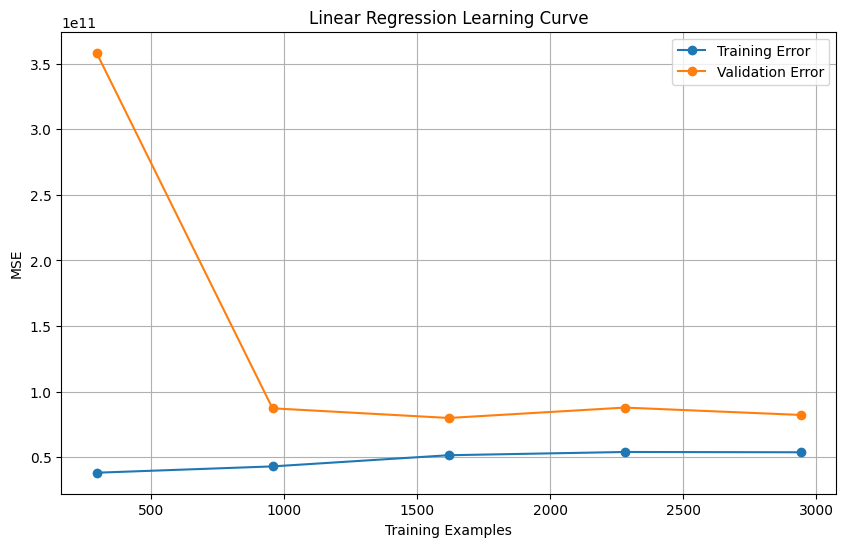

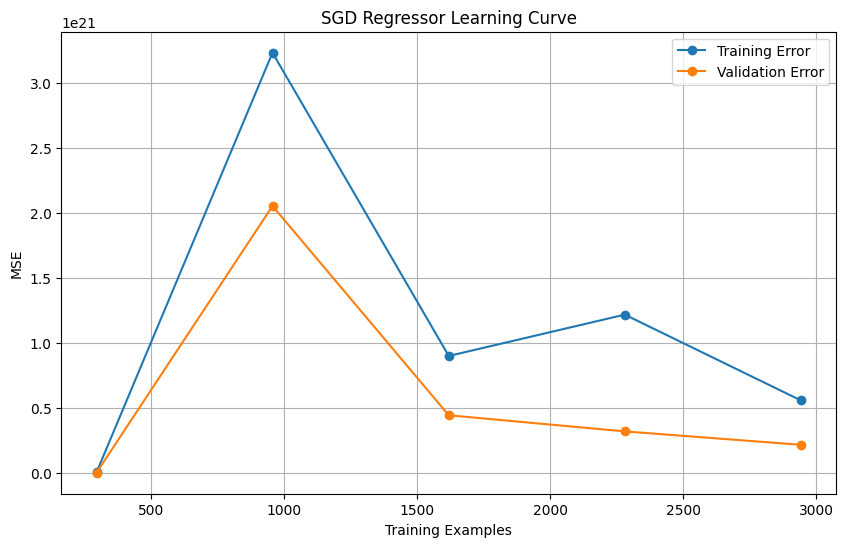

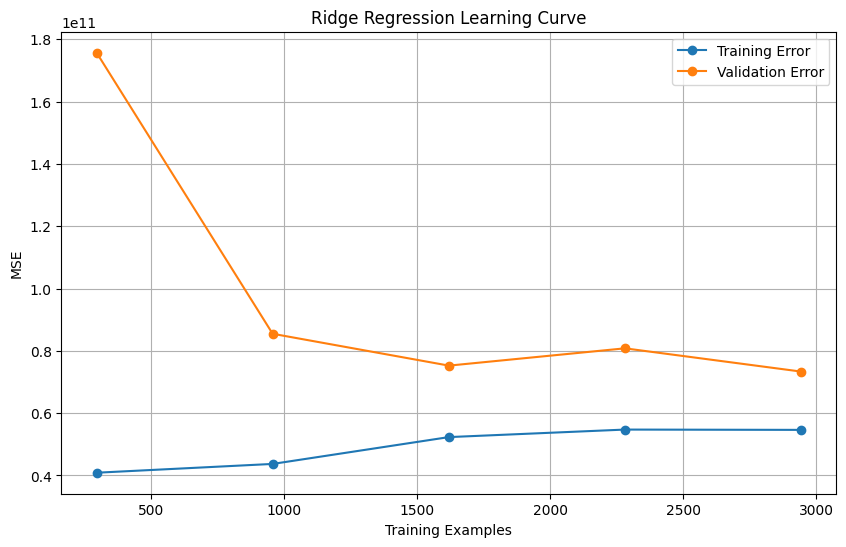

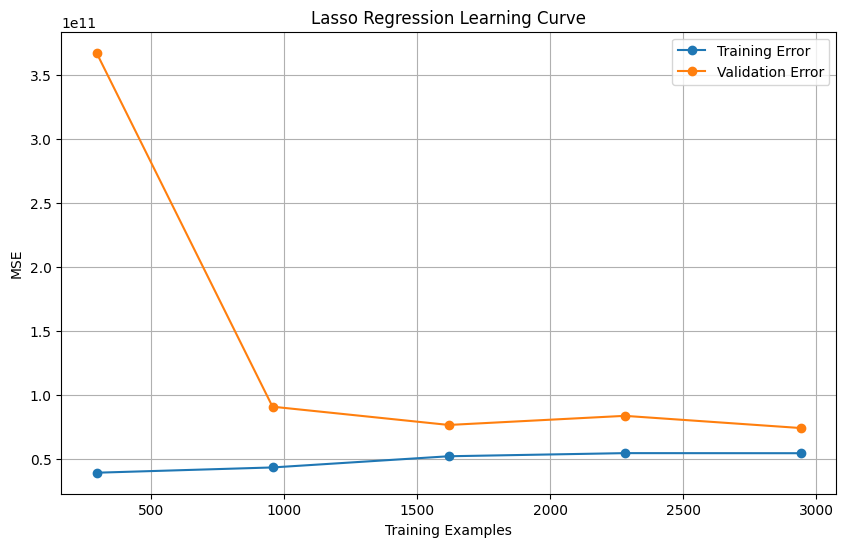

In [21]:
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', label="Training Error")
    plt.plot(train_sizes, -np.mean(val_scores, axis=1), 'o-', label="Validation Error")
    plt.xlabel("Training Examples")
    plt.ylabel("MSE")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

for name, model in models.items():
    plot_learning_curve(model, X_train_scaled, y_train, f"{name} Learning Curve")

## 6. Hyperparameter Tuning
# Ridge Regression Tuning

In [22]:
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_scaled, y_train)
print("Best Ridge alpha:", ridge_grid.best_params_)


Best Ridge alpha: {'alpha': 100}


# Lasso Regression Tuning

In [23]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5)
lasso_grid.fit(X_train_scaled, y_train)
print("Best Lasso alpha:", lasso_grid.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.292e+13, tolerance: 4.360e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.103e+13, tolerance: 4.102e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.517e+13, tolerance: 4.215e

Best Lasso alpha: {'alpha': 10}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.834e+13, tolerance: 5.229e+10
  model = cd_fast.enet_coordinate_descent(


## 7. Model Evaluation and Comparison

In [24]:
results = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test_scaled)

    results.append({
        'Model': name,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred),
        'Training Time (s)': train_time
    })

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e+14, tolerance: 5.229e+10
  model = cd_fast.enet_coordinate_descent(


# Add Logistic Regression results (classification)

In [25]:
start_time = time.time()
log_reg.fit(X_train_scaled, y_train_class)
train_time = time.time() - start_time
y_pred_log = log_reg.predict(X_test_scaled)

results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test_class, y_pred_log),
    'F1-Score': f1_score(y_test_class, y_pred_log),
    'Training Time (s)': train_time
})

# Create comparison table

In [26]:

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
display(results_df)



Model Comparison:


,Model,RMSE,R²,Training Time (s),Accuracy,F1-Score
0,Linear Regression,9.940296e+05,0.031134,0.024853,NaN,NaN
1,SGD Regressor,4.063718e+07,-1618.244006,0.135126,NaN,NaN
2,Ridge Regression,9.946171e+05,0.029988,0.006189,NaN,NaN
3,Lasso Regression,9.948014e+05,0.029628,0.429748,NaN,NaN
4,Logistic Regression,NaN,NaN,0.384929,0.765217,0.759465


## 8. Feature Importance Analysis
# For Lasso (best for feature selection)

In [27]:
best_lasso = Lasso(alpha=lasso_grid.best_params_['alpha'])
best_lasso.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.834e+13, tolerance: 5.229e+10
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=10)

# Get important features

In [28]:
importance = np.abs(best_lasso.coef_)
feature_names = poly.get_feature_names_out(input_features=X.columns)
important_features = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
display(important_features.head(10))


Top 10 Important Features:


,Feature,Importance
35,sqft_living^2,221344.673690
2,sqft_living,218917.442422
88,yr_built yr_renovated,123506.534784
38,sqft_living waterfront,122690.911283
0,bedrooms,117567.192088
22,bedrooms yr_built,117176.630532
10,yr_built,115973.593558
28,bathrooms waterfront,109141.826848
52,sqft_lot yr_built,108529.148988
6,view,95264.418574


# Plot feature importance

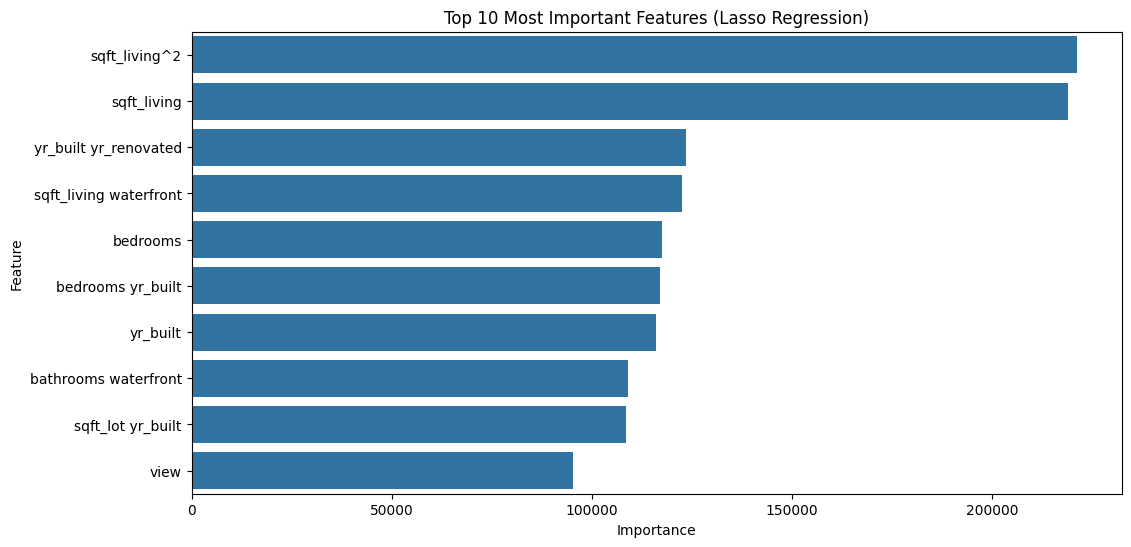

In [29]:
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=important_features.head(10))
plt.title('Top 10 Most Important Features (Lasso Regression)')
plt.show()